In [1]:
import pandas as pd
import numpy as np
import altair as alt
df = pd.read_csv("StudyEventTimeSeries.csv")

In [2]:
codelist = list(set(df.as_matrix().flatten()))
codelist.remove(np.nan)

actionOnly= list(filter(lambda x: x.isupper(),codelist))
featureOnly= list(filter(lambda x: x.islower(),codelist))

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [3]:
# df["t"]=df.index

In [4]:
df = df.stack().reset_index()

df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"action"
})

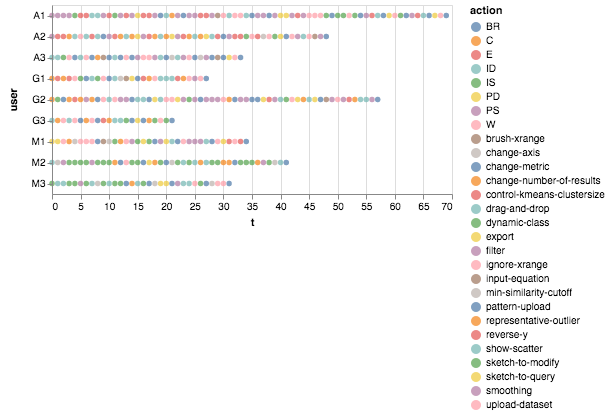

In [5]:
alt.Chart(df).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

In [7]:
df[df["action"]=="change-number-of-results"]

,t,user,action
127,14,A2,change-number-of-results
181,20,A2,change-number-of-results
231,26,A2,change-number-of-results


# Action only

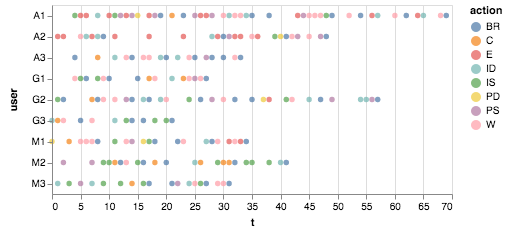

In [100]:
df_action = df[df.action.isin(actionOnly)]
alt.Chart(df_action).mark_circle().encode(        
    color='action',
    y="user",
    x='t'
)

In [101]:
# Insight and Session Breaks

In [102]:
df_break = df[df.action.isin(["BR"])]
break_chart = alt.Chart(df_break).mark_tick(thickness=2,color="black").encode(        
    y="user",
    x='t'
)

In [103]:
df_insight = df[df.action.isin(["IS","ID"])]
df_insight.loc[df_insight["action"]=="ID","action"]="data insight"
df_insight.loc[df_insight["action"]=="IS","action"]="scientific insight"
insight_chart = alt.Chart(df_insight).mark_point(shape="diamond",color="red").encode(        
    alt.Y("user",title="Participant"),
    alt.X("t",title="Timepoint"),
    shape='action' #make no distinction between data and science insights
)


/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


# Feature Only

In [104]:
df_feature = df[df.action.isin(featureOnly)]
df_feature["Feature"] = df_feature["action"]
feature_chart = alt.Chart(df_feature).mark_circle().encode(        
    alt.Color("Feature"),
    y="user",
    x='t'
)

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


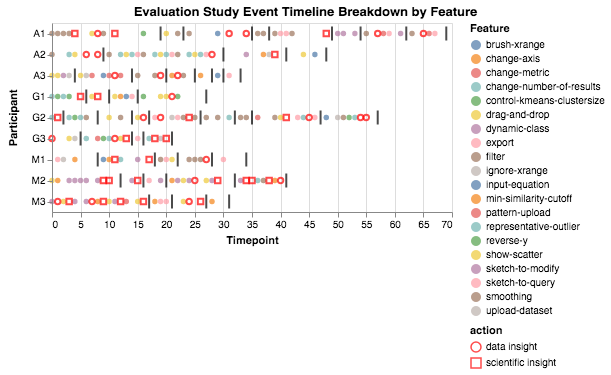

In [105]:
chart = feature_chart+ break_chart + insight_chart
chart.title="Evaluation Study Event Timeline Breakdown by Feature"
chart

In [106]:
# df_feature = df[~df.action.isin(featureOnly)]

# Key Components

In [107]:
component_dict = {
     'pattern-upload':'concept-query',
     'sketch-to-modify':'exact-specification',
     'drag-and-drop':'result-querying',
     'change-metric':'flexible-matching',
     'filter':'filter-selection',
     'brush-xrange':'range-selection',
     'min-similarity-cutoff':'control',
     'smoothing':'approx-shape-specification',
     'ignore-xrange':'approx-shape-specification',
     'representative-outlier':'recommendation',
     'dynamic-class':'group-comparison',
     'sketch-to-query':'exact-specification',
     'reverse-y':'control',
     'input-equation':'exact-specification',
     'upload-dataset':'control',
     'show-scatter':'control',
     'export':'control',
     'change-number-of-results':'control',
     'control-kmeans-clustersize':'recommendation',
     'change-axis':'control'
}

In [108]:
df_component = df_feature
df_component["action"] = df_feature["action"].replace(component_dict)
df_component= df_component.rename(index=str,columns={"action":"component"})

/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [109]:
# df_component = df_component[df_component["component"]!="control"] #remove control in list of components

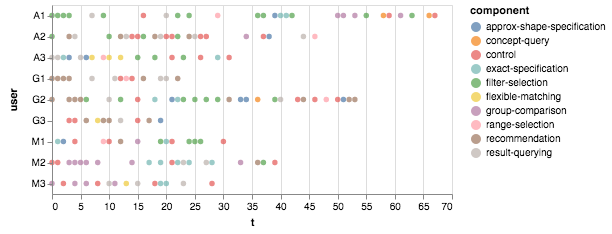

In [110]:
alt.Chart(df_component).mark_circle().encode(        
    color='component',
    y="user",
    x='t'
)

# Adding some event action information back in

In [186]:
component_chart = alt.Chart(df_component).mark_circle(opacity=1).encode(        
    color=alt.Color('component',title="Component"),
    y="user",
    x='t'
)

In [187]:
sum_events = df.groupby("user").count().reset_index()[["user","t"]]

In [188]:
sum_events["t"] = sum_events["t"]-1

In [191]:
guide = alt.Chart(sum_events).mark_bar(color="gray",opacity=0.25,size=3).encode(        
    y="user",
    x=alt.X('t',aggregate="sum",title="Timepoint")
)

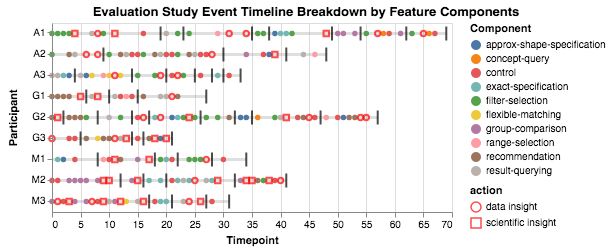

In [192]:
chart = guide+component_chart+ break_chart + insight_chart
chart.title="Evaluation Study Event Timeline Breakdown by Feature Components"
chart

- Astronomers discovered insights more about their data, whereas geneticists and material scientists uncovered more scientific insights.
- The use of exact specification (including sketch) is rare, and doesn't usually lead to useful outcomes. 

# Processes

In [75]:
td = 'top-down-querying'
sc = 'search-with-context'
bu = 'bottom-up-querying'
rec= 'recommendation'
component_to_process = {
    'exact-specification':td,
    'approx-shape-specification':td,
    'flexible-matching':td,
    'range-selection':td, 
    'filter-selection':sc, 
    'group-comparison':sc,
    'result-querying':bu,
    'concept-query':bu,
    'control':"others",
    'recommendation':rec,
}

In [76]:
df_process = df_component
df_process["Process"] = df_component["component"].replace(component_to_process)

In [77]:
process_chart = alt.Chart(df_component).mark_circle().encode(        
    alt.Color("Process",sort=[td,sc,bu,rec]),
    y="user",
    x='t'
)

In [78]:
df_break = df[df.action.isin(["BR"])]
break_chart = alt.Chart(df_break).mark_tick(thickness=2,color="black").encode(        
    y="user",
    x='t'
)

In [79]:
df_insight = df[df.action.isin(["IS","ID"])]
df_insight.loc[df_insight["action"]=="ID","Action"]="data insight"
df_insight.loc[df_insight["action"]=="IS","Action"]="scientific insight"
insight_chart = alt.Chart(df_insight).mark_point(shape="diamond",color="red").encode(        
    alt.Y("user",title="Participant"),
    alt.X("t",title="Timepoint"),
    shape='Action' #make no distinction between data and science insights
)


/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dorislee/.virtualenvs/py37env/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


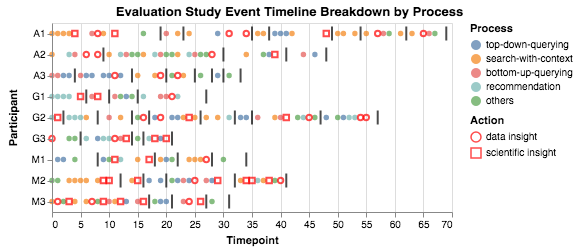

In [80]:
chart = process_chart+ break_chart + insight_chart
chart.title="Evaluation Study Event Timeline Breakdown by Process"
chart

- Top-down querying alone does not lead to insights. We see a lot of sessions where people try top-down querying then give up without discovering an insight. Even when there is top-down querying performed sucessfully, it is often because it was associated with a search with context, or used for sketch modification on a drag-and-dropped visualization.

# Statistics

In [81]:
print ("Total number of sessions:", len(df[df["action"]=="BR"]))

Total number of sessions: 50


In [82]:
df['subject'] = df['user'].apply(lambda x: {'A':'astro', 'G':'genetics', 'M':'material science'}[x[0]])

In [83]:
df[df["action"]=="BR"].groupby("subject").count().reset_index()[["subject","t"]].rename(columns={"t":"Number of Sessions"}).transpose()

,0,1,2
subject,astro,genetics,material science
Number of Sessions,19,17,14


In [84]:
df = pd.read_csv("StudyEventTimeSeries.csv")

df = df.stack().reset_index()

df = df.rename(columns={
    "level_0":"t",
    "level_1":"user",
    0:"Feature"
})

In [85]:
df = df[df.Feature.isin(featureOnly)]

In [86]:
df['subject'] = df['user'].apply(lambda x: {'A':'astro', 'G':'genetics', 'M':'material science'}[x[0]])

In [87]:
df_frequency_by_subject_feature = df.groupby(["subject","Feature"]).count()["t"].reset_index().rename(columns={"t":"Usage Frequency"})

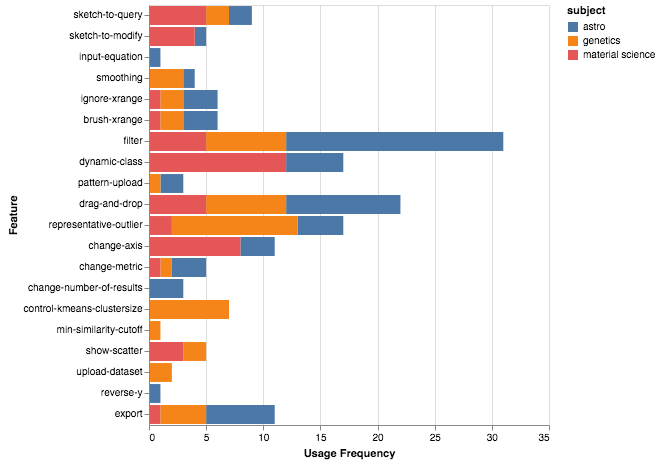

In [88]:
alt.Chart(df_frequency_by_subject_feature).mark_bar().encode(
    alt.X("Usage Frequency"),
    alt.Y("Feature",sort= ['sketch-to-query','sketch-to-modify','input-equation','smoothing','ignore-xrange','brush-xrange',
                          'filter','dynamic-class','pattern-upload','drag-and-drop','representative-outlier',
                          'change-axis', 'change-metric','change-number-of-results','control-kmeans-clustersize', 'min-similarity-cutoff','show-scatter', 'upload-dataset','reverse-y']),
    color = "subject"
)

In [89]:
df_component = df
df_component["Component"] = df["Feature"].replace(component_dict)

df_frequency_by_subject_feature = df.groupby(["subject","Component"]).count()["t"].reset_index().rename(columns={"t":"Usage Frequency"})

# df_frequency_by_subject_feature = df_frequency_by_subject_feature[df_frequency_by_subject_feature["Component"]!="control"]

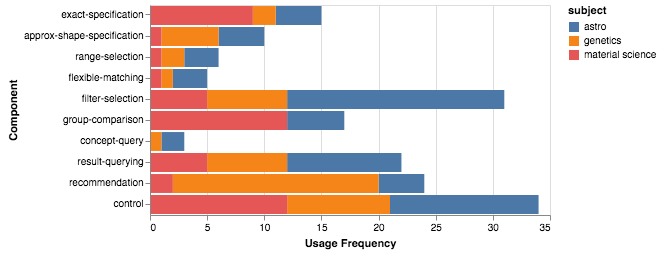

In [90]:
alt.Chart(df_frequency_by_subject_feature).mark_bar().encode(
    alt.X("Usage Frequency"),
    alt.Y("Component",sort=['exact-specification','approx-shape-specification','range-selection','flexible-matching',
                            'filter-selection','group-comparison',
                            'concept-query', 'result-querying','recommendation','control']),
    color = "subject"
)

In [91]:
df_process = df_component
df_process["Process"] = df_component["Component"].replace(component_to_process)

In [92]:
df_frequency_by_subject_feature = df.groupby(["subject","Process"]).count()["t"].reset_index().rename(columns={"t":"Usage Frequency"})

In [93]:
df_frequency_by_subject_feature = df_frequency_by_subject_feature[df_frequency_by_subject_feature["Process"]!="others"]

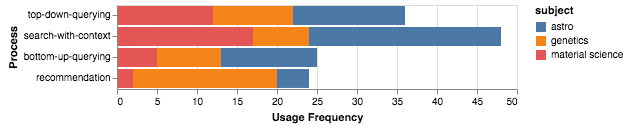

In [94]:
alt.Chart(df_frequency_by_subject_feature).mark_bar().encode(
    alt.X("Usage Frequency"),
    alt.Y("Process",sort=[td,sc,bu,rec]),
    alt.Color("subject")
)

Most of the contribution of top-down querying is coming from changing metric, brush x-range, ignore-xrange, not just the sketching portion. 

In [39]:
df_process[df_process["Process"]=="top-down-querying"].groupby("Feature").count().rename(columns={"t":"Usage Frequency"}).reset_index()[["Feature","Usage Frequency"]].transpose()

,0,1,2,3,4,5,6
Feature,brush-xrange,change-metric,ignore-xrange,input-equation,sketch-to-modify,sketch-to-query,smoothing
Usage Frequency,6,5,6,1,5,9,4


### Top k feature for each subject 

In [40]:
df_frequency_by_subject_feature = df.groupby(["subject","Feature"]).count()["t"].reset_index().rename(columns={"t":"Usage Frequency"})

In [41]:
df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="astro"].nlargest(5,"Usage Frequency")

,subject,Feature,Usage Frequency
7,astro,filter,19
4,astro,drag-and-drop,10
6,astro,export,6
5,astro,dynamic-class,5
11,astro,representative-outlier,4


In [42]:
df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="material science"].nlargest(5,"Usage Frequency")

,subject,Feature,Usage Frequency
34,material science,dynamic-class,12
31,material science,change-axis,8
33,material science,drag-and-drop,5
36,material science,filter,5
41,material science,sketch-to-query,5


In [43]:
df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="genetics"].nlargest(5,"Usage Frequency")

,subject,Feature,Usage Frequency
25,genetics,representative-outlier,11
18,genetics,control-kmeans-clustersize,7
19,genetics,drag-and-drop,7
21,genetics,filter,7
20,genetics,export,4


### Feature usage scaled by individual subject area 

In [44]:
astro_sum = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="astro"]["Usage Frequency"].sum()
genetics_sum = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="genetics"]["Usage Frequency"].sum()
matsci_sum = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="material science"]["Usage Frequency"].sum()

In [45]:
df_frequency_by_subject_feature.loc[df_frequency_by_subject_feature["subject"]=="astro","Normalized Frequency"] = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="astro"]["Usage Frequency"]/astro_sum*100
df_frequency_by_subject_feature.loc[df_frequency_by_subject_feature["subject"]=="genetics","Normalized Frequency"] = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="genetics"]["Usage Frequency"]/genetics_sum*100
df_frequency_by_subject_feature.loc[df_frequency_by_subject_feature["subject"]=="material science","Normalized Frequency"] = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="material science"]["Usage Frequency"]/matsci_sum*100

In [46]:
fdf = df_frequency_by_subject_feature[["subject","Feature","Normalized Frequency"]]
fdf = fdf[fdf["Normalized Frequency"]>=5]

In [47]:
fdf["Normalized Frequency"] = fdf["Normalized Frequency"].map("{:.2f}".format)

In [48]:
fdf

,subject,Feature,Normalized Frequency
4,astro,drag-and-drop,14.93
5,astro,dynamic-class,7.46
6,astro,export,8.96
7,astro,filter,28.36
11,astro,representative-outlier,5.97
18,genetics,control-kmeans-clustersize,13.46
19,genetics,drag-and-drop,13.46
20,genetics,export,7.69
21,genetics,filter,13.46
25,genetics,representative-outlier,21.15


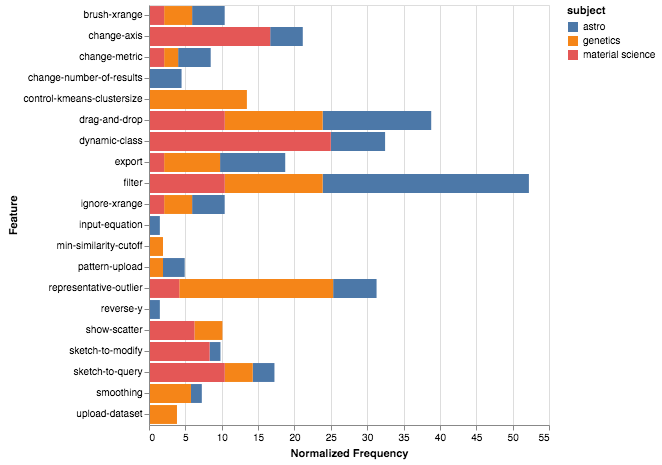

In [49]:
alt.Chart(df_frequency_by_subject_feature).mark_bar().encode(
    x= "Normalized Frequency",
    y= "Feature",
    color="subject"
)

In [50]:
#df_frequency_by_subject_feature["Component"] = df_feature["Feature"].replace(component_dict)

In [51]:
df_frequency_by_subject_feature = df.groupby(["subject","Component"]).sum().reset_index().rename(columns={"t":"Usage Frequency"})
astro_sum = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="astro"]["Usage Frequency"].sum()
genetics_sum = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="genetics"]["Usage Frequency"].sum()
matsci_sum = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="material science"]["Usage Frequency"].sum()
df_frequency_by_subject_feature.loc[df_frequency_by_subject_feature["subject"]=="astro","Normalized Frequency"] = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="astro"]["Usage Frequency"]/astro_sum*100
df_frequency_by_subject_feature.loc[df_frequency_by_subject_feature["subject"]=="genetics","Normalized Frequency"] = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="genetics"]["Usage Frequency"]/genetics_sum*100
df_frequency_by_subject_feature.loc[df_frequency_by_subject_feature["subject"]=="material science","Normalized Frequency"] = df_frequency_by_subject_feature[df_frequency_by_subject_feature["subject"]=="material science"]["Usage Frequency"]/matsci_sum*100

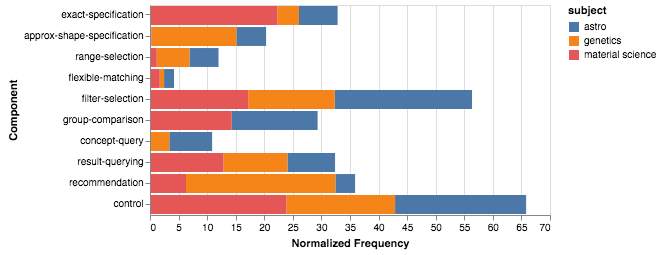

In [52]:
alt.Chart(df_frequency_by_subject_feature).mark_bar().encode(
    x= alt.X("Normalized Frequency"),
    y= alt.Y("Component",sort=['exact-specification','approx-shape-specification','range-selection','flexible-matching',
                            'filter-selection','group-comparison',
                            'concept-query', 'result-querying','recommendation','control']),
    color="subject"
)